In [3]:
import sys
import os
import chardet
#os.chdir("nsf")
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import xgboost as xgb
import multiprocessing
#import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import preprocessing

from pandas.api.types import is_numeric_dtype
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold, chi2, f_regression, r_regression, RFECV, RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model, tree, ensemble
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import plot_tree

In [5]:
# enc = preprocessing.OrdinalEncoder()
# X = np.array([10, 20, 35, 55, 100])

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler to your data and transform it
# ss_scaled = scaler.fit_transform(X.reshape(-1,1))
# ss_enc = enc.fit_transform(X.reshape(-1,1))

# ss_scaled, ss_enc

### **Functions**

In [6]:
today = datetime.today()

def melt_ntop(df, ntop=5, column = "first_gift_fund"):

    # make everything lower case
    if not is_numeric_dtype(df[column]):
        df[column] = df[column].str.lower()
    
    # Filter out rows with NA values in column
    threshold = len(df) * 0.05

    df_ntop = df.dropna(subset=[column]) \
        .groupby(column) \
        .filter(lambda x: len(x) > threshold) \
        .groupby(column) \
        .size() \
        .sort_values(ascending=False) \
        .reset_index(name='count')
    
    # Get the top 5 funds
    top_vars = df_ntop[column].tolist()    
    
    # Create new columns for each of the top 5 funds
    for var in top_vars:
        var_str = str(var).replace(".", "_").replace('@', '_').replace(' ', '_')
        var_column_name = "%s_%s_binary" %(column, var_str)
        var_column_name = var_column_name.replace('__', '_')
        df[var_column_name] = df[column].apply(lambda x: 1 if x == var else 0)

    df = df.drop(columns=column)

    return(df)

def calculate_age(birth_date):
    if isinstance(birth_date, str):
        birth_date = datetime.strptime(birth_date, '%Y-%m-%d')
        today = datetime.now()
        age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
        fraction = (today - birth_date.replace(year=today.year)).days / 365.25
        age_decimal = age + fraction
        return age_decimal
    else:
        return np.nan

import numpy as np

def bin_and_convert_to_binary(ages):

    # Define bin edges
    bin_edges = [0, 30, 40, 50]

    # Bin the ages into groups
    binned_ages = np.digitize(ages, bins=bin_edges)
    
    # Convert binned ages into binary representation
    binary_ages = np.eye(len(bin_edges) + 1)[binned_ages]
    
    return binary_ages

### **Constituent File**

In [7]:
path = "/home/RMittal@ccsfundraising.com/ccs_pred_mod"
filename =  "national_scleroderma_foundation_constituent_ccsdb.csv"
file = "%s/%s" %(path, filename)
df_cd = pd.read_csv(file, encoding="ISO-8859-1")

In [8]:
# df_cd = df_cd.merge(final1[["constituent_id", "first_gift_fund_1_0002_binary",
#  "last_gift_fund_1_0002_binary", "largest_gift_fund_1_0002_binary"]], on="constituent_id", how="left")

In [9]:
# Remove columns with less than 5% non-empty values
#cleaned_df = df_cd.dropna(axis=1, thresh=len(df_cd)*0.05)

### **Drop unwanted columns**

In [10]:
### Unnamed
columns_to_drop=["Unnamed: 0", "org_name", "wealth_screen_data", "attributes"]
for col in columns_to_drop:
    if col in df_cd.keys().to_list():
        df_cd = df_cd.drop(columns=col)

### **Spouse**

In [11]:
### has_spouse_binary
df_cd["has_spouse_binary"] =  df_cd.filter(like='spouse').notna().any(axis=1).astype(int)
columns_to_drop = ["spouse_id", "spouse_name", "spouse_business_name", \
                   "spouse_business_title", "spouse_email"]
df_cd = df_cd.drop(columns=columns_to_drop)

### **Date to Age**

In [12]:
# Convert Date of Birth to Age in Decimal
columns_age = ["age", "spouse_age"]
for col in columns_age:
    df_cd[col] = pd.to_datetime(df_cd[col])
    dob_array = df_cd[col]
    ages_decimal = np.array(["%2.2f" %((today - dob).days/365.25) for dob in dob_array]).astype(float)
    ages_decimal[ages_decimal < 0] = np.nan
#    ages_decimal = [calculate_age(date) for date in dob]
    df_cd = df_cd.drop(columns=[col])
    df_cd[col] = ages_decimal

### **Age Binning**

In [13]:
col = "age"
bin_edges = [0, 30, 40, 50, 200]
A = pd.cut(df_cd[col], bins=bin_edges, labels=False, right=False)

# Convert binned ages into binary representation
binary_ages = pd.get_dummies(A, prefix=col)

# Join the binary columns to the original DataFrame
df_cd = pd.concat([df_cd, binary_ages], axis=1)

# Rename the binary columns
binary_column_names = ["%s_%s_binary" %(col, edge) for edge in bin_edges[1:]]
column_mapping = {binary_ages.keys().to_list()[i]:binary_column_names[i] for i in range(len(binary_ages.keys()))}
df_cd.rename(columns=column_mapping, inplace=True)

### **Dates to Days**

In [14]:
column_dates = [key for key in df_cd.keys() if "date" in key.lower()] + ["class_year"]
for col in column_dates:
#    print(col)
    df_cd[col] = pd.to_datetime(df_cd[col])
    col_days = (today - df_cd[col]).dt.days
    col_days[col_days < 0] = np.nan
    df_cd = df_cd.drop(columns=col)
    df_cd[col] = col_days

### **Prefix**

In [15]:
df_cd["prefix"] = df_cd["prefix"].astype(str)
df_cd["prefix_has_dr_binary"] = df_cd["prefix"].str.contains(r"(dr|prof)", case=False).astype(int)
df_cd = df_cd.drop(columns=["prefix"])

### **Incomplete address**

In [16]:
df_cd["incomplete_address_binary"] = ((df_cd['address_1'].isna()) | (df_cd['home_city'].isna()) | \
                               (df_cd['home_state'].isna()) | (df_cd['zip'].astype(str).str.len() < 5)).astype(int)

### **Presence/Absence**

In [17]:
columns_binaries = ["middle_name", "address_2", "head_of_household", "number_of_children", \
                    "history_of_volunteer", "employer_name", "business_address", \
                    "seasonal_address", "business_email", \
                    "home_phone", "cell_phone", "business_phone"]
# Convert non-null entries into binary columns
binary_df = pd.get_dummies(df_cd[columns_binaries].notnull().astype(int))
column_mapping = {key:"%s_binary" %key for key in binary_df.keys()}
binary_df.rename(columns=column_mapping, inplace=True)

# Drop the original columns
df_cd = df_cd.drop(columns=columns_binaries)

# Concatenate the binary columns with the original DataFrame
df_cd = pd.concat([df_cd, binary_df], axis=1)

### **TOP 5 BINARIES**

In [18]:
### Any Columns with Email
#col_emails = [key for key in df_cd.keys() if "email" in key.lower()]
col_emails = ["personal_email"]
for col in col_emails:
#    print(col)
    df_cd[col] = df_cd[col].astype(str)
    if len(df_cd[df_cd[col].notna()]) & len(df_cd[df_cd[col]!="nan"])>0:
        col_type = df_cd[col].str.split(pat="@", expand=True)[1]
        df_cd = df_cd.drop(columns=col)
        df_cd[col] = col_type
        df_cd = melt_ntop(df=df_cd, ntop=5, column=col)

In [19]:
#constit_data["home_state"].value_counts()
columns = ["home_city", "home_state", "suffix", "last_action_type", "marital_status",\
          "constituent_type_1", "constituent_type_2", "number_of_special_events_attended"]
for col in columns:
    #print(col)
    df_cd = melt_ntop(df=df_cd, ntop=5, column=col)

### **Filters and Indicators**

In [20]:
df_cd = df_cd.drop(columns=["is_deceased", "is_individual"])
df_cd = df_cd[(df_cd["deceased"].str.contains("no", case=False)) & \
              (df_cd["key_indicator"].str.contains("I", case=False)) &\
              (df_cd["home_country"].str.contains("USA|U\.S\.A\.|United States|America", case=False)) ]
df_indicators = pd.concat([df_cd.pop(col) for col in ["deceased", "key_indicator"]], axis=1)

### **Taggers**

In [21]:
column_taggers = ["constituent_id", "first_name", "last_name", "home_country", "address_1", "zip",\
                  "current_trustee", "past_trustee", "assigned_manager", \
                  "lifetime_hard_credits", "lifetime_soft_credits", \
                  "first_gift_amount", "most_recent_gift_amount", "number_of_gifts"]
df_taggers = pd.concat([df_cd.pop(col) for col in column_taggers], axis=1)

### **Sklearn -- preprocessing**

In [22]:
### Drop all columns that are NaN
df_reg = df_cd.dropna(how="all", axis=1)

### Drop all columns where 80% of the entires are NaN
df_reg = df_reg.dropna(axis=1, thresh=len(df_reg)*0.20)

### Convert the lifetime giving into log1p
df_reg["lifetime_giving"] = np.log1p(df_reg["lifetime_giving"])/np.log(10)

columns_binary = [key for key in df_reg.keys() if "binary" in key.lower()]
if len(columns_binary)>0:
    df_reg_subset = pd.concat([df_reg.pop(col) for col in columns_binary], axis=1)
else:
    df_reg_subset = pd.DataFrame()
df_reg_subset["m_giving_logp1"] = df_reg.pop("lifetime_giving")

X = df_reg

In [23]:
# Preprocessing the predictors (scaling numeric variables and encoding categorical variables, feature_selection etc)
#numeric_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
#categorical_features = X.select_dtypes(include=["object", "string", "O"]).columns.tolist()
numeric_features = [col for col in X.columns if is_numeric_dtype(X[col])]
categorical_features = [col for col in X.columns if not is_numeric_dtype(X[col])]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder(min_frequency=0.05))
    # You may need to add encoding steps for categorical features here
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)
#X_processed = np.hstack((np.array(y)[:, np.newaxis], X_processed))

In [24]:
# Reset indices of X_processed and df_reg_subset
df_reg_subset = df_reg_subset.reset_index(drop=True)

final = pd.concat([pd.DataFrame(data=X_processed, columns=X.columns), \
                             df_reg_subset], axis=1)
final = final.dropna(how="any")
m_giving_logp1 = final.pop('m_giving_logp1')
#final.isnull().sum().any()
#plt.figure(figsize=(4, 2))
#final1.m_giving_logp1.hist()

In [25]:
final.shape, X_processed.shape, df_reg_subset.shape

((151515, 44), (219102, 6), (219102, 39))

In [26]:
# plt.figure(figsize=(4, 2))
# final.number_of_special_events_attended.hist(bins=100)
# plt.yscale('log')

# plt.figure(figsize=(4, 2))
# plt.scatter(final.number_of_special_events_attended, m_giving_logp1)
# plt.xlim(0, 20)

## **Feature Selection**

In [27]:
### y
y = m_giving_logp1
### All columns
xcol_all = final.keys().tolist()

#### **Variance Threshold**
Feature selector that removes all low-variance features.

In [28]:
X = final[xcol_all]
threshold = 0.05
selector = VarianceThreshold(threshold=threshold)
X_reduced = selector.fit_transform(X, y)

cols = selector.get_support(indices=True)
ncols = len(cols)
globals() ["xcol_var_%d" %(threshold*100)] = X.iloc[:,cols].columns.tolist()
print(len(globals() ["xcol_var_%d" %(threshold*100)]))

29


#### **F_Statistic Threshold**
Univariate linear regression tests returning F-statistic and p-values.

In [29]:
q = 0.01
dfn = 1
dfd = len(X) - 2
f01 = sp.stats.f.isf(q, dfn, dfd)

In [30]:
X = final[xcol_all]
f_stat, p_values = f_regression(X, y)
cols_f_stat = list(np.where(f_stat>f01)[0])
xcol_f_stat = X.iloc[:,cols_f_stat].columns.tolist()
# plt.figure(figsize=(4, 2))
# g = plt.hist(f_stat, bins=20, color="red")
len(xcol_f_stat)

33

#### **Pearson_R Threshold**
Univariate linear regression tests returning the Pearson Correlation Coefficient.

In [31]:
X = final[xcol_all]
r_pearson = np.abs(r_regression(X, y))
cols = list(np.where(r_pearson>=np.mean(r_pearson))[0])
ncols = len(cols)
xcol_rpearson_mean = X.iloc[:,cols].columns.tolist()
len(xcol_rpearson_mean)
#g = plt.hist(r_pearson, bins=20)
#sns.boxplot(r_pearson)

14

#### **Recursive Feature Elimination**

In [32]:
xgb.__version__

'2.0.3'

In [ ]:
%%time

est_dict = {"lm": linear_model.LinearRegression(), "xgb": xgb.XGBRegressor(booster="gbtree"), \
            "xgbrf": xgb.XGBRFRegressor(), "svr": SVR(kernel="linear"), \
            "rf": RandomForestRegressor(n_estimators=100, oob_score=True, bootstrap=True, random_state=42)
           }
#            "rf": ensemble.RandomForestRegressor()}

# est = "svr" ### Takes too long!! I had to stop after 15 minutes
# est = "rf" ### Takes too long!! I had to stop after 15 minutes
# est = "lm"
est = "xgb"

estimator = est_dict[est]

run = True 
if run:
    X = final[xcol_all]
    y = m_giving_logp1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    #rfe = RFE(estimator=estimator, step=1, n_features_to_select=25, verbose=2)
    rfe = RFECV(estimator=estimator, step=1, min_features_to_select=1, verbose=2, \
                n_jobs=(multiprocessing.cpu_count()//2), cv=3,\
                scoring="neg_mean_squared_error")
    print("Fitting %s" %est)
    rfe.fit(X=X_train, y=y_train)
    print(f"Optimal number of features: {rfe.n_features_}")

    cols = rfe.get_support(indices=True)
    globals()["xcol_rfe_%s" %est] = X.iloc[:,cols].columns.tolist()
#    len(xcol_rfe)
#    sum(rfe.ranking_==1)

In [981]:
#np.abs(rfe.estimator_.coef_)

In [325]:
### Only for RFECV

run=False
if run:
    n_scores = len(rfe.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(0, n_scores),
        rfe.cv_results_["mean_test_score"],
        yerr=rfe.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.show()

In [242]:
folds = 5

# List of models to be tested
algorithms = {"LR": linear_model.LinearRegression(), "GBR": ensemble.GradientBoostingRegressor(), \
              "XGBR": xgb.XGBRegressor(), "XGBRF": xgb.XGBRFRegressor(),\
              "DTR": tree.DecisionTreeRegressor()}

### X
features = {"all": xcol_all, "var_1": xcol_var_1, "var_10": xcol_var_10, "var_5": xcol_var_5, \
            "f_stat": xcol_f_stat, "r_pearson": xcol_rpearson_mean,\
             "rfecv_xgb": xcol_rfe_xgb, "rfe_lm": xcol_rfe_lm}
            # "f_stat_med": xcol_f_stat_med,

model_results = {}
model_pred = {}
model_stats = {}
model_evaluation = {}

y = m_giving_logp1
for feature_type, cols in features.items():
    
    X = final[cols]
    
    # Creating a training set index by partitioning the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    print("feature_type = %10s | No. of cols = %3d" %(feature_type, len(cols)))
    
    model_results[feature_type] = {}
    model_pred[feature_type] = {}
    model_stats[feature_type] = {}
    model_evaluation[feature_type] = {}
    
    globals() ["model_df_%s" %(feature_type)] = pd.DataFrame({"Features": X.keys().tolist()})
    for algo_name, model in algorithms.items():
        
        ### Fitting
#        print(feature_type, algo_name)
        scores = cross_val_score(model, X_train, y_train, cv=folds, scoring='neg_root_mean_squared_error')
        results = model.fit(X_train, y_train)
        y_pred = results.predict(X_test)
    
        ### Statistics
        # Calculate MAE, MSE and RMSE
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
    
        ### Populate the dictionaries and the dataframe
        model_results[feature_type][algo_name] = results
        model_pred[feature_type][algo_name] = y_pred
        model_stats[feature_type][algo_name] = [mae, mse, rmse]
        model_evaluation[feature_type][algo_name] = -scores.mean()
        
        try:
            globals() ["model_df_%s" %(feature_type)]["Coeff_%s" %algo_name] = model.coef_
        except:
            pass  

# Your list of tuples
data = [(key, len(features[key]), key1, model_stats[key][key1][2]) for key in model_stats.keys() for key1 in model_stats[key].keys()]

# Create a DataFrame
df = pd.DataFrame(data, columns=["Feature_Selection", "N_Features", "Estimator", "Root_Mean_Square_Error"])

feature_type =        all | No. of cols =  47
feature_type =      var_1 | No. of cols =  37
feature_type =     var_10 | No. of cols =  17
feature_type =      var_5 | No. of cols =  32
feature_type =     f_stat | No. of cols =  36
feature_type =  r_pearson | No. of cols =  16
feature_type =  rfecv_xgb | No. of cols =  27
feature_type =     rfe_lm | No. of cols =  44


In [243]:
#[(key, len(features[key]), key1, model_stats[key][key1]) for key in model_stats.keys() for key1 in model_stats[key].keys()]
df.sort_values(["Root_Mean_Square_Error"])
#df

,Feature_Selection,N_Features,Estimator,Root_Mean_Square_Error
2,all,47,XGBR,0.316000
37,rfe_lm,44,XGBR,0.316000
7,var_1,37,XGBR,0.316022
22,f_stat,36,XGBR,0.316060
32,rfecv_xgb,27,XGBR,0.316624
17,var_5,32,XGBR,0.316936
12,var_10,17,XGBR,0.319180
27,r_pearson,16,XGBR,0.320730
11,var_10,17,GBR,0.332360
16,var_5,32,GBR,0.333239


In [364]:
rmse_nick

0.39409353703163746

#### **Feature Importance**

In [369]:
%%timeit
### Single Estimator
run = True
if run:
    X = final
    y = m_giving_logp1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    model = xgb.XGBRegressor()
    results = model.fit(X_train, y_train)
    y_pred = results.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(rmse)

0.34142061468932866
0.34142061468932866
0.34142061468932866
0.34142061468932866
0.34142061468932866
0.34142061468932866
0.34142061468932866
0.34142061468932866
1.4 s ± 190 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
### By default the importance_type='gain' but other options can be selected 
### such as weight, gain, cover, Total_gain and Total_cover 
### XGBRegressor(importance_type='weight')
m1 = model_results["rfecv_xgb"]["XGBR"]
cols = xcol_rfe_xgb
X = final[cols]
importances = m1.feature_importances_
pd.Series(importances, index=X.columns).sort_values(ascending=False)[0:10]

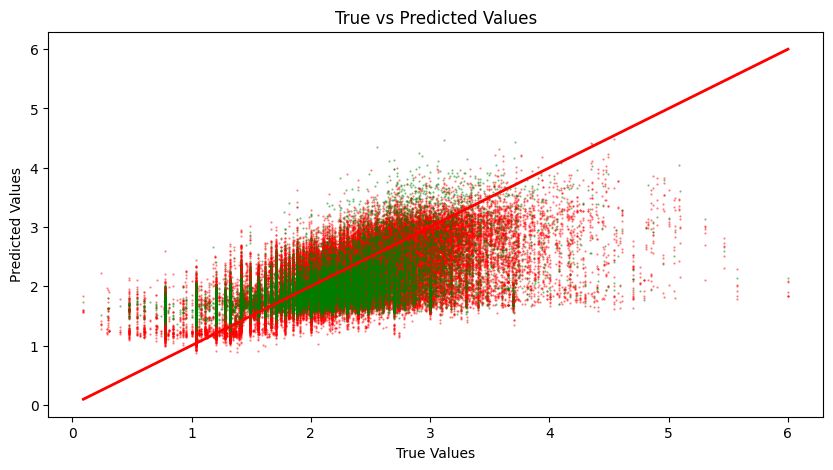

In [192]:
colors = cm.prism(np.linspace(0, 1, len(model_pred.keys())))
plt.figure(figsize=(10, 5))
i=0
for key in model_pred.keys():
    plt.scatter(y_test, model_pred[key]["XGBR"], color=colors[i], alpha=0.5, s=0.3)
    i += i
plt.scatter(y_test, y_pred_nick, color='green', alpha=0.5, s=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

In [152]:
# import seaborn as sns

# plt.figure(figsize=(10, 5))
# sns.violinplot(x=y_test, y=predictions)
# plt.xlabel('True Values')
# plt.ylabel('Predicted Values')
# plt.title('Violin Plot of Predicted Values for Each True Value')
# plt.show()

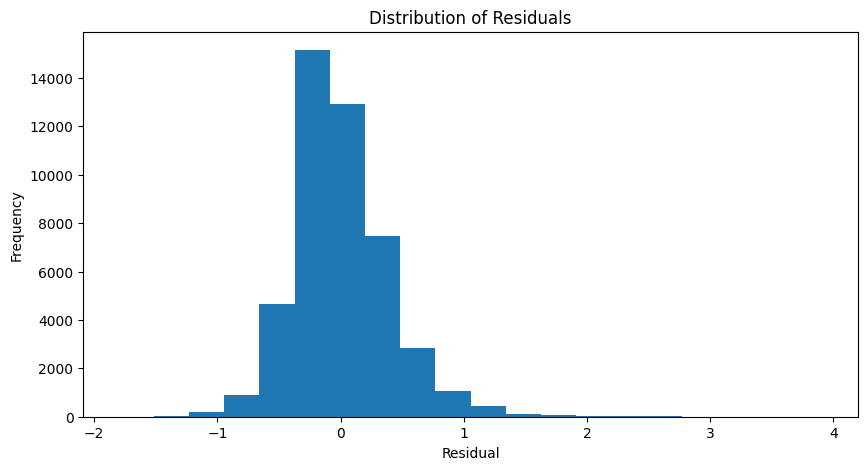

In [178]:
residuals = y_test - predictions

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [38]:
#plt.scatter(data['five_year_giving'], data['total_lifetime_giving'])

***Main***

In [4]:
x = ['home_state', 'most_recent_gift_date', 'first_gift_date', 'five_year_giving']
y = "total_lifetime_giving"

data = pd.read_csv("data.csv")
data.columns = data.columns.str.replace(" ", "_")
data = data.replace(np.nan, "None")

start_time = datetime.now()
models = perform_regression(data=data, y=y, x=x, top_labels=5, folds=5, sizes=[5],
                            algorithms=["XGBRegressor", "XGBRf_statressor"])
end_time = datetime.now()
elapsed_time = end_time - start_time
print(elapsed_time)

# "trained_models": trained_models,
# "evaluation_results": evaluation_results,
# "testing_data": (X_test, y_test),
# "best_model": best_model

0:00:00.900876


In [162]:
models["evaluation_results"]

{'XGBRegressor': 1.0687633225578452}